In [1]:
import sys
sys.path.append('E:/Graduate Study Material/ML/Assignments/hw2')
import mltools as ml
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# P1: Linear Regression
## 1.1

In [2]:
path = "E:/Graduate Study Material/ML/Assignments/hw2/data/curve80.txt"
data = np.genfromtxt(path, delimiter = None)   # load the data
X = data[:, 0]
X = np.atleast_2d(X).T 
# code expects shape (M,N) so make sure it's 2-dimensional
Y = data[:, 1]   # doesn't matter for Y
Xtr,Xte,Ytr,Yte = ml.splitData(X, Y, 0.75)   # split data set 75/25

In [3]:
print('Shapes of Xtr:', Xtr.shape)
print('Shapes of Xte:', Xte.shape)
print('Shapes of Ytr:', Ytr.shape)
print('Shapes of Yte:', Yte.shape)

Shapes of Xtr: (60, 1)
Shapes of Xte: (20, 1)
Shapes of Ytr: (60,)
Shapes of Yte: (20,)


## 1.2
### 1.2.1

Through linearRegress class, we can create a linear regression predictor of y given x. After densely sampling possible x-values, we can plot the prediction function.

In [5]:
lr = ml.linear.linearRegress(Xtr, Ytr)   # create and train model
xs = np.linspace(0, 10, 200)   # densely sample possible x-values
xs = xs[:, np.newaxis] 
# force "xs" to be an Mx1 matrix (expected by our code)
ys = lr.predict(xs)   # make predictions at xs

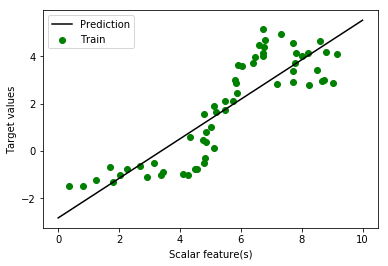

In [6]:
plt.scatter(Xtr, Ytr, color='green', label='Train')
plt.plot(xs, ys, color='black', label='Prediction')
plt.legend()
plt.xlabel('Scalar feature(s)')
plt.ylabel('Target values')
plt.show()

### 1.2.2

In [7]:
print('Linear regression coefficient:', lr.theta)

Linear regression coefficient: [[-2.82765049  0.83606916]]


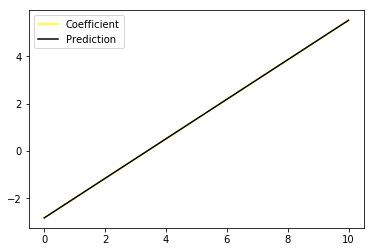

In [8]:
# using the Linear regression coefficient to plot the pridiction function 
# and compare with the original pridiction function
ysTheta = lr.theta[0][0] + lr.theta[0][1] * xs
plt.plot(xs, ysTheta, color='yellow', label='Coefficient')
plt.plot(xs, ys, color='black', label='Prediction')
plt.legend()
plt.show()

The intercept of prediction function is -2.82765049 while the slope is 0.83606916. Since the two plots are the same, it can be verified that the coefficients match the plot.

### 1.2.3

We can simplely use the mse function in class regressor to compute the mean squared error. Since class linearRegress is a subclass of regressor, we can use it directly on lr.

In [9]:
print('MSE of training data: %.4f\nMSE of test data: %.4f' \
      % (lr.mse(Xtr,Ytr),lr.mse(Xte,Yte)))

MSE of training data: 1.1277
MSE of test data: 2.2423


## 1.3
### 1.3.1

To avoid pasting the same code multiple times, we can define a function "Phi(X)" to do the required feature expansion and rescaling.

In [10]:
def Phi(X):
    """Outputs the expanded and scaled feature matrix
    Args:
          X (arr): M x N array that contains M data points 
                   with N features
    Returns:
          arr: expanded and scaled array of X    
    """       
    global degree, params
    # use degree and params as global variables so that 
    # they can be memorized.
    (result, params) = ml.transforms.rescale (ml.transforms.fpoly\ 
    (X , degree , False), params)
    return result

For each degree, we can plot the learned prediction functions f(x) and MSE of training&test data. To make the prediction functions more clear, I also  plot it along with the training&test data points.

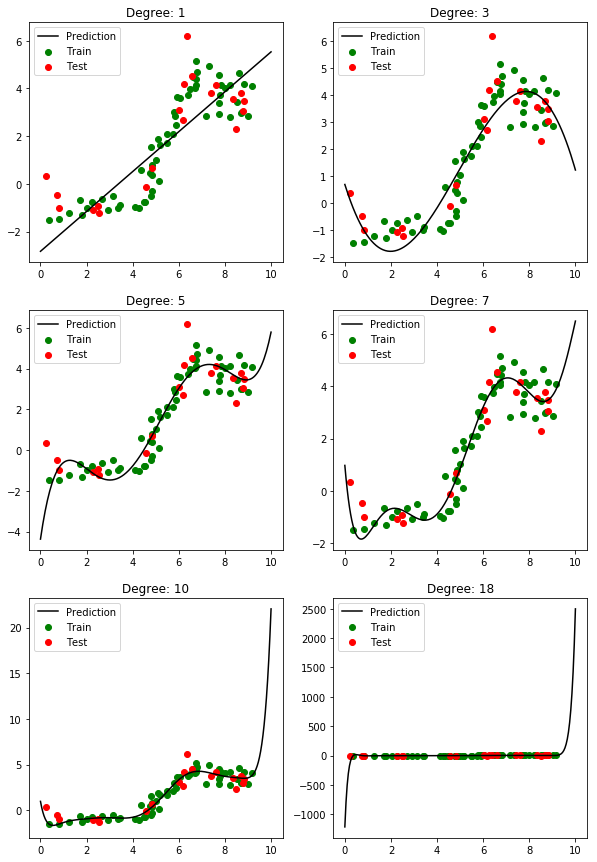

In [11]:
D = [1,3,5,7,10,18]   
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
# Create a single figure with several subplots  
mseTrain = np.zeros(len(D))
mseTest = np.zeros(len(D))
# Create mseTrain and mseTest to store MSE of training data and test data

for i,degree in enumerate(D):
    params = (None, None)
    lr = ml.linear.linearRegress(Phi(Xtr), Ytr)
    # train model on the scaled feature matrix of training data
    yshat = lr.predict(Phi(xs))    # predict on xs
    ax[i//2][i%2].plot(xs, yshat, color='black', label='Prediction')
    ax[i//2][i%2].scatter(Xtr, Ytr, color='green', label='Train')
    ax[i//2][i%2].scatter(Xte, Yte, color='red', label='Test')
    ax[i//2][i%2].legend()
    ax[i//2][i%2].set_title('Degree: %s' % degree)
    # use i//2, i%2 to control the row and column of the axes
    
    mseTrain[i] = lr.mse(Phi(Xtr), Ytr)
    mseTest[i] = lr.mse(Phi(Xte), Yte)
    # compute MSE of training data and test data for diffenrent degrees
plt.show()

Let's plot the picture of training and test errors (on a log scale) as a function of the degree.

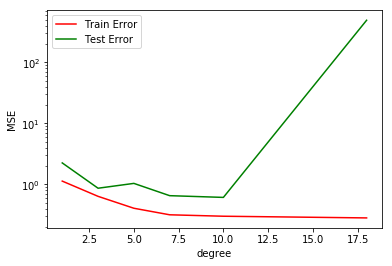

In [12]:
plt.semilogy(D, mseTrain,color='red', label='Train Error')
plt.semilogy(D, mseTest,color='green', label='Test Error')
plt.legend()
plt.xlabel('degree')
plt.ylabel('MSE') 
plt.show()

### 1.3.2

Based on the plot in (b), degree = 10 had the lowest test error, so I would most likely choose that. You can also see evidence of overfitting (degree = 18; low training error but high test error) and of underfitting (degree = 1,3,4,7; high training and test errors).

# P2: Cross-validation
## 2.1

Let's firstly define a function "crossVal(nFolds)" to compute the cross-validation error of a specified number of folds.

In [13]:
def crossVal(nFolds):
    """Outputs the cross-validation error of n folds
    nFolds(integar): number of folds(training/validation splits)

    Returns:
          float: the cross-validation error of n folds
    """        
    J = np.zeros(nFolds)
    # create a list to store the MSE of Xvi, Yvi for each iFold
    for iFold in range(nFolds):
        Xti,Xvi,Yti,Yvi = ml.crossValidate(Xtr,Ytr,nFolds,iFold) 
        # use ith block as validation
        learner = ml.linear.linearRegress(Phi(Xti),Yti) 
        # train on Xti, Yti, the data for this fold
        J[iFold] = learner.mse(Phi(Xvi), Yvi) 
        # compute the MSE on Xvi, Yvi and save it
    return np.mean(J)
    # the overall estimated validation error is the average of the 
    # error on each fold

In [14]:
errCVofDegree = np.zeros(len(D))
# Create errCVofDegree to store cross-validation error for different degrees
for i,degree in enumerate(D):
    params = (None, None)
    errCVofDegree[i] = crossVal(5)

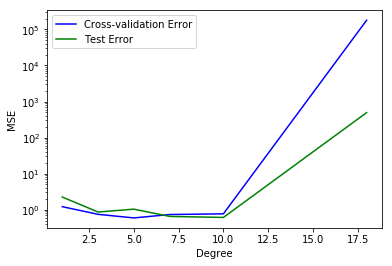

In [18]:
# Plot the five-fold cross-validation error and test error as a function 
# of degree
plt.semilogy(D,errCVofDegree,color='blue',label='Cross-validation Error')
plt.semilogy(D,mseTest,color='green',label='Test Error')
plt.legend()
plt.xlabel('Degree')
plt.ylabel('MSE') 
plt.show()

## 2.2

The common of them is that they both decrease when degree = 1,3; fluctuate within a narrow range when degree = 5,7,10; sharply increase when degree raises to 18.

The difference is that when degree raises to 18, MSE estimates from five-fold cross-validation is much bigger than the MSEs evaluated on the actual test data.

## 2.3

Based on the plot, degree = 5 had the lowest five-fold cross-validation error, so I would most likely choose that.

## 2.4

Set degree = 5, the plot is below.

In [16]:
degree = 5
Folds = [2,3,4,5,6,10,12,15]
errCVofFold = np.zeros(len(Folds))
# Create errCVofFold to store cross-validation error for different 
# number of fold
for i,n in enumerate(Folds):
    params = (None, None)
    errCVofFold[i] = crossVal(n)

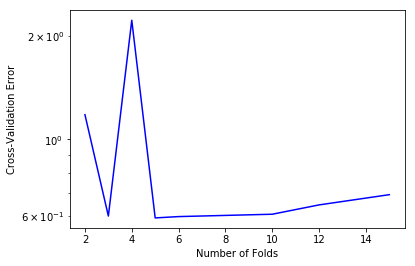

In [19]:
# Plot the cross-validation error as a function of the number of folds
plt.semilogy(Folds, errCVofFold,color='blue')
plt.xlabel('Number of Folds')
plt.ylabel('Cross-Validation Error') 
plt.show()

The pattern shows that as the number of folds increases, cross-validation error will firstly decreases, secondly increases, thirdly decreases and then increases. 

The explanation for it may be when number of folds is either too smal or too large, the error will be large, which is kind of like underifitting and overfitting. As for when we have 4 folds, the cross-validation error achieves the largest, I think it may be a special case and will randomly occur.

# Statement of Collaboration